In [2]:

COLORS = {
    'reset': '\033[0m',

    'red': '\033[31m',
    'green': '\033[32m',
    'yellow': '\033[33m',
}

def GetColor(color_name: str) -> str:
    return COLORS.get(color_name, COLORS['reset'])

def Colored(text: str, color_name: str = 'green') -> str:
    return f"{GetColor(color_name)}{text}{GetColor('reset')}"


In [ ]:
import numpy as np

def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()


In [4]:
def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    history.append([Round(percentage_industry), total_people, start, Round(people[0]), Round(people[1])])

    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append([Round(percentage_industry), total_people, year, Round(people[0]), Round(people[1])])

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    percentage_people_industry: float,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> np.ndarray:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results


In [5]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)

In [24]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 20
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 10
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 5
stepSamplePercentagePeopleIndustry = 0.1

In [25]:

Responses = Simulation(
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

# Responses



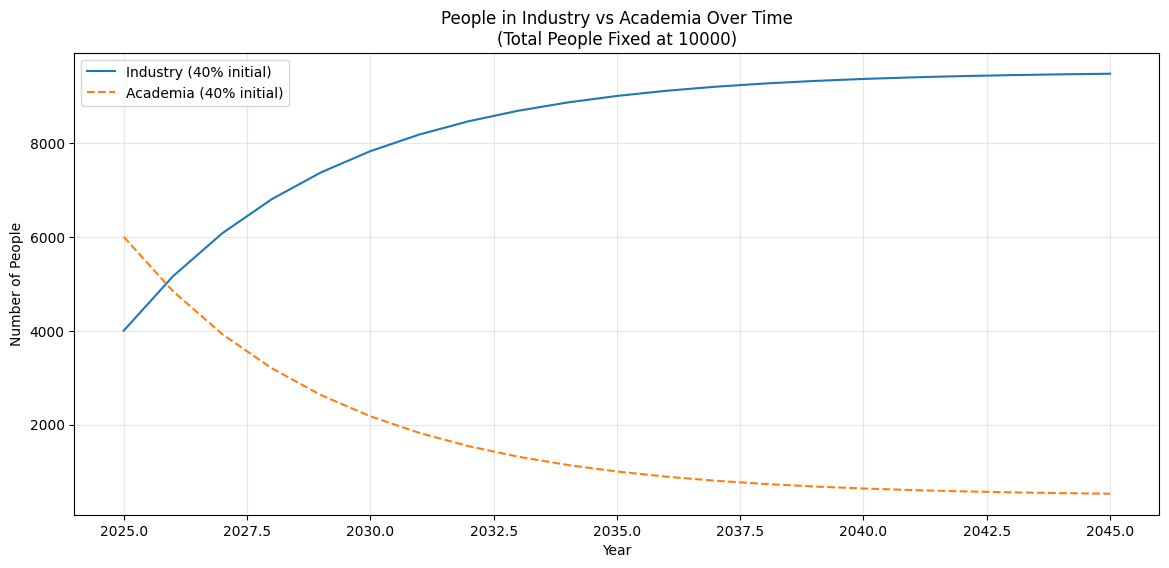

In [26]:
import matplotlib.pyplot as plt

def PlotByFixedTotalPeople(responses, total_people_index: int):
    plt.figure(figsize=(14, 6))
    
    # Get the slice of the data for the fixed total people index
    data_slice = responses[total_people_index]
    
    # Get unique percentages to label the plots
    percentages = np.unique(data_slice[:, 0])

    for percentage in percentages:
        # Filter data for the current percentage
        current_data = data_slice[data_slice[:, 0] == percentage]
        
        # Unpack the data for plotting
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]
        
        # Plot Industry and Academia on the same axes for comparison
        plt.plot(years, industry, label=f'Industry ({percentage:.0%} initial)')
        plt.plot(years, academia, linestyle='--', label=f'Academia ({percentage:.0%} initial)')

    plt.title(f'People in Industry vs Academia Over Time\n(Total People Fixed at {data_slice[0, 1]:.0f})')
    plt.xlabel('Year')
    plt.ylabel('Number of People')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot for the first total people sample (1000 people)
PlotByFixedTotalPeople(Responses, total_people_index=3)


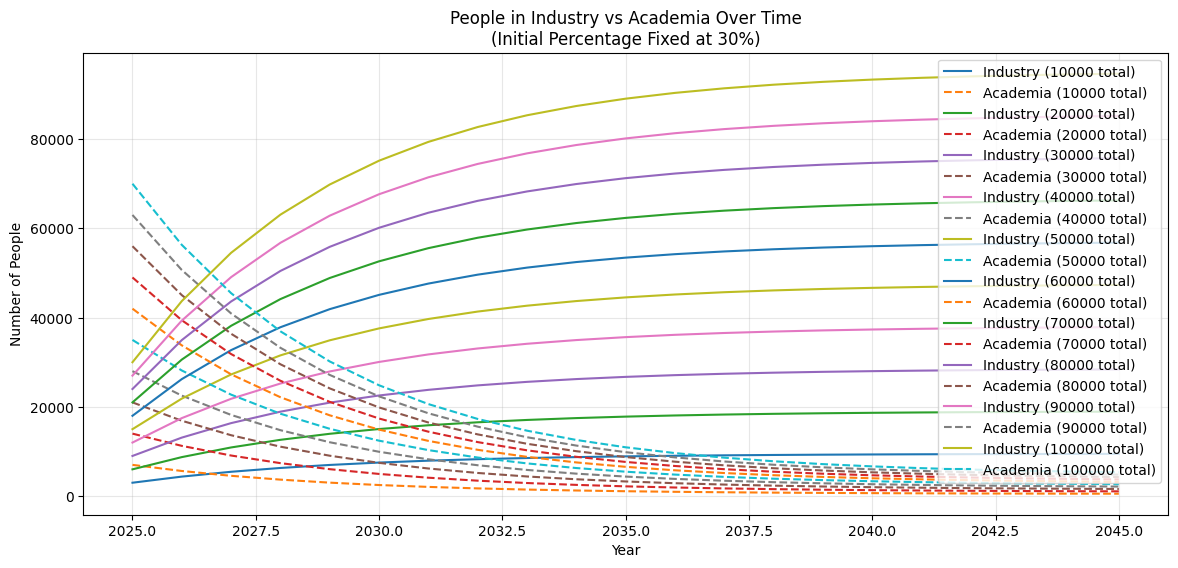

In [ ]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(responses, percentage_index: int):
    plt.figure(figsize=(14, 6))

    # Get the slice of data for the fixed percentage
    data_slice_flat = np.concatenate(responses, axis=0) # Flatten the list of arrays
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_slice_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_slice_flat[data_slice_flat[:, 0] == target_percentage]
    
    # Get unique total people counts
    total_people_counts = np.unique(data_at_percentage[:, 1])

    for total_people in total_people_counts:
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes
        plt.plot(years, industry, label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, linestyle='--', label=f'Academia ({total_people:.0f} total)')

    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage Fixed at {target_percentage:.0%})')
    plt.xlabel('Year')
    plt.ylabel('Number of People')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot for the first percentage sample (10% initial)
PlotByFixedPercentage(Responses, percentage_index=2)

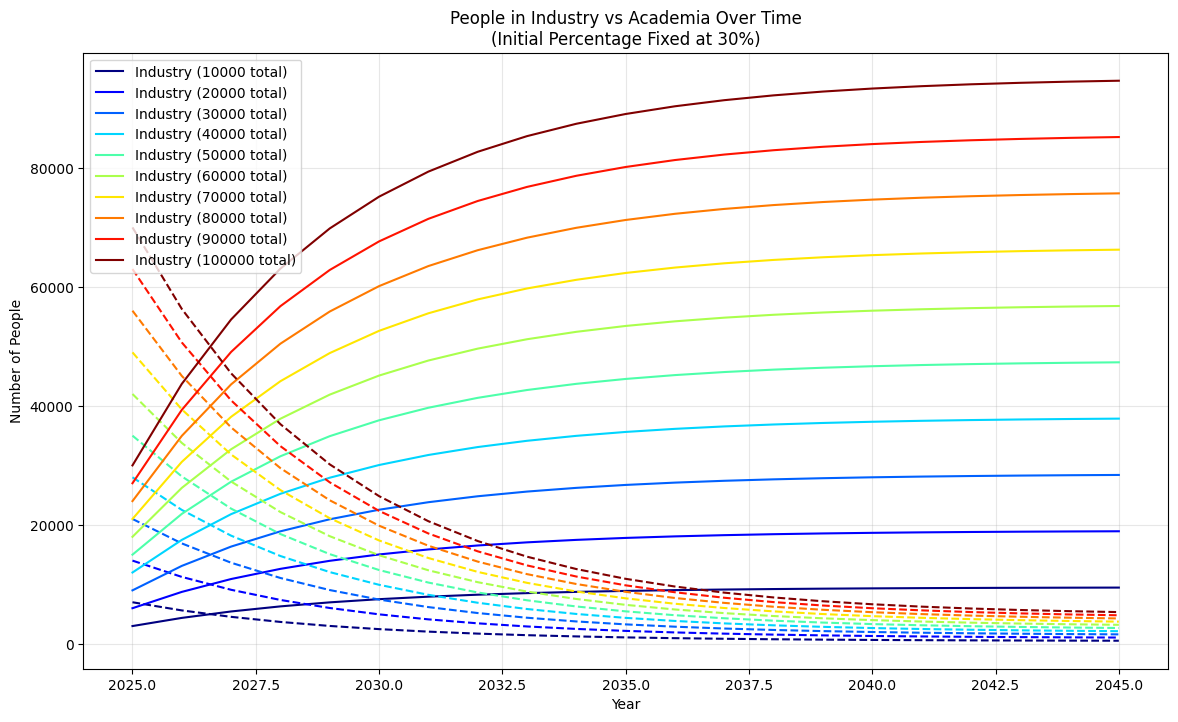

In [36]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(responses, percentage_index: int):
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage Fixed at {target_percentage:.0%})')
    plt.xlabel('Year')
    plt.ylabel('Number of People')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot for the third percentage sample (30% initial)
PlotByFixedPercentage(Responses, percentage_index=2)

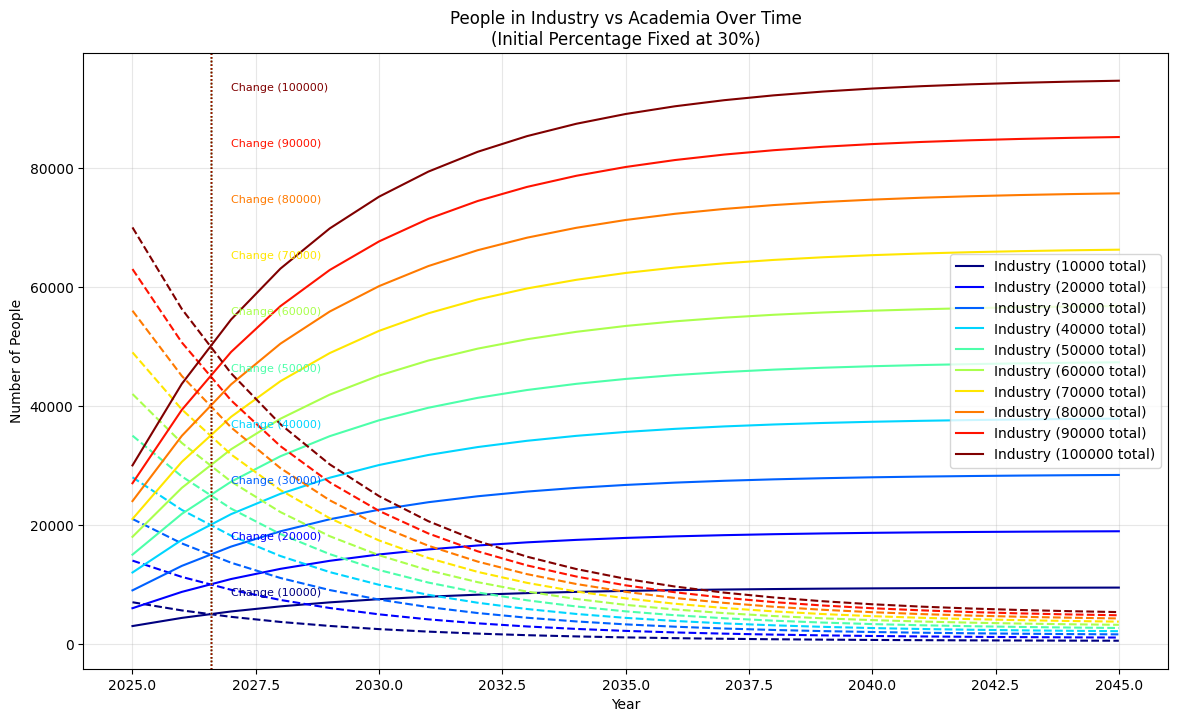

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def FindChangeYearsFromUnpacked(X_axis: np.ndarray, Y_axis_industry: np.ndarray, Y_axis_academia: np.ndarray) -> list[int]:
    """
    Finds and returns a list of years where the leading group (industry vs. academia) changes.
    This is an adapted version of your FindChangeYears function to work with unpacked data.
    """
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    # Filter out cases where the leader remains 'equal'
    valid_changes = [idx for idx in change_indices if leader_array[idx] != 0]
    change_years = X_axis[np.array(valid_changes) + 1]
    return change_years.tolist()

def PlotByFixedPercentage(responses, percentage_index: int):
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]

        # Unpack the data
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

        # Find the year of change and plot a vertical line
        change_years = FindChangeYearsFromUnpacked(years, industry, academia)
        if change_years:
            for year in change_years:
                plt.axvline(x=year-0.4, color=colors[i], linestyle=':', linewidth=1)
                plt.text(year, plt.ylim()[1]*0.95, f'Change ({total_people:.0f})', rotation=0, color=colors[i], fontsize=8, verticalalignment='top')
                
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage Fixed at {target_percentage:.0%})')
    plt.xlabel('Year')
    plt.ylabel('Number of People')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage: Plot for the third percentage sample (30% initial)
# Assumes 'Responses' is a list of NumPy arrays as generated by your Simulation function
PlotByFixedPercentage(Responses, percentage_index=2)

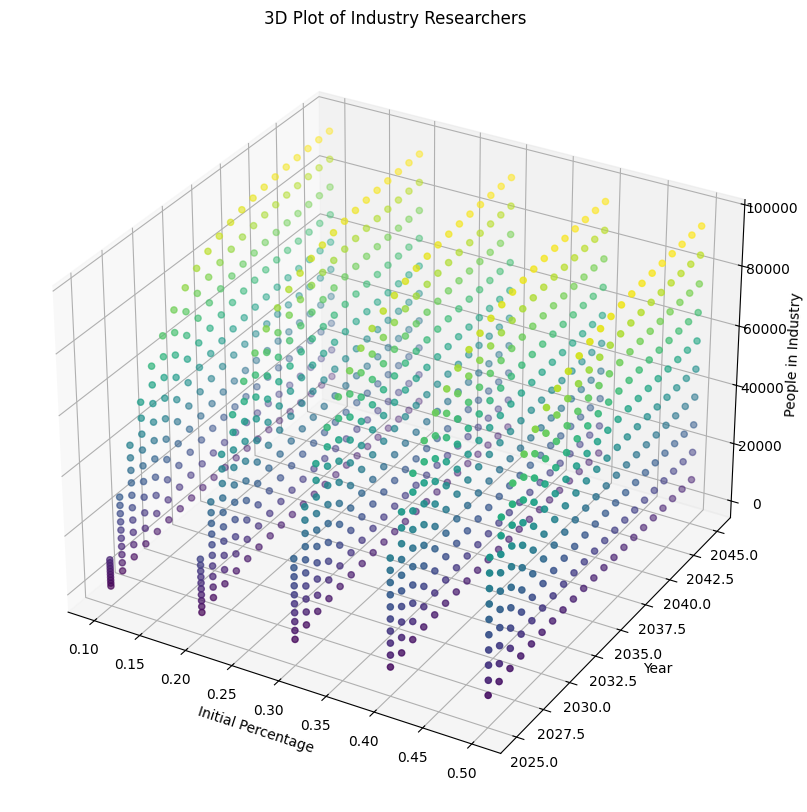

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def Plot3D(responses):
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # We flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0)
    
    # Extract data for plotting
    percentages = data_flat[:, 0].astype(float)
    total_people = data_flat[:, 1].astype(float)
    years = data_flat[:, 2].astype(float)
    industry = data_flat[:, 3].astype(float)
    
    # Create the 3D scatter plot
    ax.scatter(percentages, years, industry, c=industry, cmap='viridis')
    
    ax.set_xlabel('Initial Percentage')
    ax.set_ylabel('Year')
    ax.set_zlabel('People in Industry')
    ax.set_title('3D Plot of Industry Researchers')
    
    plt.show()

# Example usage (assuming 'Responses' is the output of your Simulation function)
Plot3D(Responses)